In [4]:
from dataset import SIMDataset

In [5]:
my_filename = "data/4-SIM-merge-18frames.tif"
dataset = SIMDataset(my_filename)

Extract two frames. Let's try to align two neighboring z-slices of the same illumination pattern--the easiest case.

In [6]:
frame1 = dataset.get_subimage(0, 0, 0)
frame2 = dataset.get_subimage(0, 1, 0)

In [7]:
import cv2
import numpy as np
from scipy.ndimage import sobel
import matplotlib.pyplot as plt

In [8]:
def convert_to_8bit(image):
    """
    Convert an image to 8-bit.
    """
    # Normalize the image to 0-1
    normalized_img = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Scale to 0-255 and convert to uint8
    img_8bit = (normalized_img * 255).astype(np.uint8)

    return img_8bit

In [9]:
def apply_sobel(image):
    """Apply Sobel operator to an image for edge detection."""
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    sobel_edge = np.hypot(sobel_x, sobel_y)
    return sobel_edge

def align_images(image1, image2):
    """Align two images using feature matching."""

    if image1.dtype != np.uint8 or image2.dtype != np.uint8:
        raise ValueError("Both images must be 8-bit")
    # Detect ORB features
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    # Match features
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score and keep the best matches
    matches = sorted(matches, key=lambda x: x.distance)[:30]

    # Extract matched points
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Compute homography
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Warp image
    height, width = image2.shape
    aligned_image = cv2.warpPerspective(image1, h, (width, height))

    return aligned_image

In [10]:
# Convert frames to grayscale if they are in color
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY) if len(frame1.shape) == 3 else frame1
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY) if len(frame2.shape) == 3 else frame2

In [11]:
# Apply Sobel operator
sobel_frame1 = apply_sobel(frame1_gray)
sobel_frame2 = apply_sobel(frame2_gray)

In [12]:
# Align images
aligned_frame = align_images(convert_to_8bit(sobel_frame1), convert_to_8bit(sobel_frame2))

In [13]:
aligned_frame

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 124, 175, 202],
       [  0,   0,   0, ..., 197, 103,  73],
       [  0,   0,   0, ..., 163,  45,   0]], dtype=uint8)

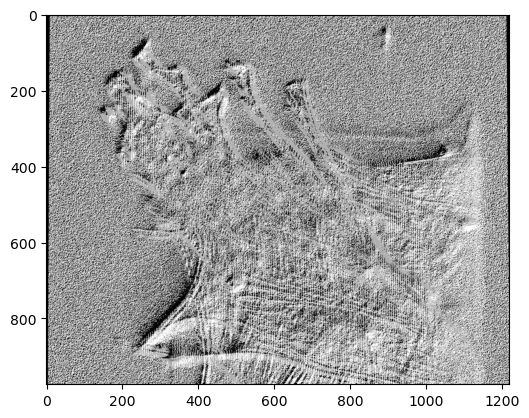

In [14]:
plt.imshow(aligned_frame, cmap='gray')

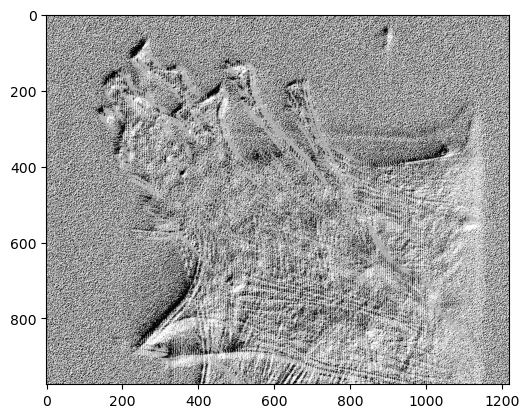

In [15]:
plt.imshow(sobel_frame1, cmap='gray')

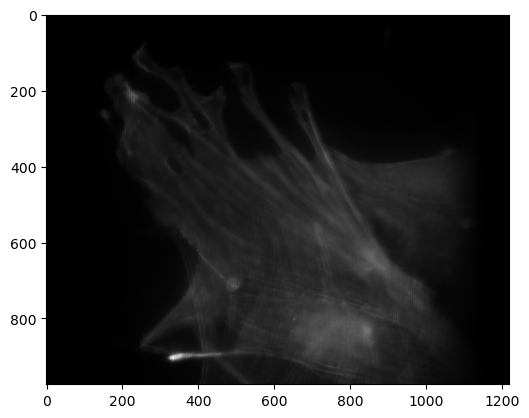

In [16]:
plt.imshow(frame2, cmap='gray')

In [17]:
# Display results
cv2.imshow("Original Frame", frame1_gray)
cv2.imshow("Aligned Frame", aligned_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
def show_image_difference(original, modified):
    """Show the difference between two images using matplotlib."""
    # Convert images to grayscale if they are not already
    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original

    if len(modified.shape) == 3:
        modified_gray = cv2.cvtColor(modified, cv2.COLOR_BGR2GRAY)
    else:
        modified_gray = modified

    # Compute the absolute difference
    difference = cv2.absdiff(original_gray, modified_gray)

    # Display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(modified_gray, cmap='gray')
    plt.title('Modified Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference')
    plt.axis('off')

    plt.show()

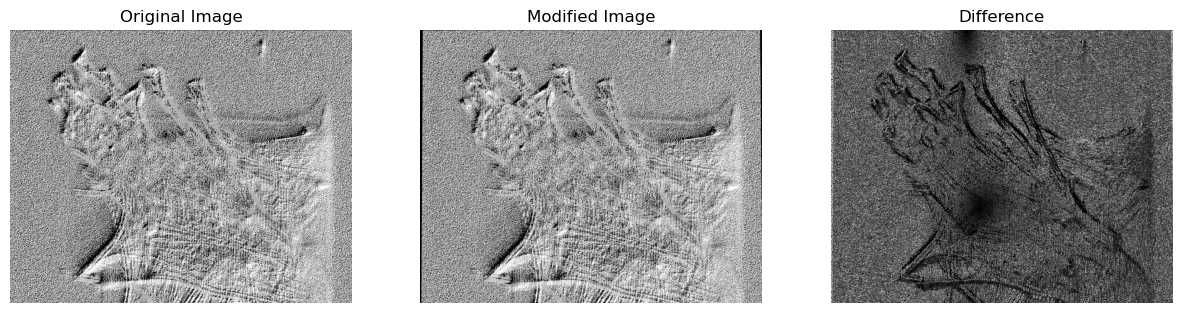

In [21]:
show_image_difference(convert_to_8bit(sobel_frame1), aligned_frame)

### Extracting alignment transformation

1. Apply the Sobel operator.
1. Find the transformation that maps one image to another.
1. Apply the transformation to the original images.

In [22]:
def find_transformation(image1, image2):
    """Find the transformation matrix to align image1 to image2."""
    # Feature detection and matching
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract the matched points
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find the homography (transformation matrix)
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)
    return h

def align_image_using_known_transform(original_image, transformation_matrix):
    """Apply the transformation matrix to the original image."""
    height, width = original_image.shape[:2]
    aligned_image = cv2.warpPerspective(original_image, transformation_matrix, (width, height))
    return aligned_image

In [24]:
original_image1 = frame1_gray
original_image2 = frame2_gray

# Apply Sobel operator to both images
sobel_image1 = apply_sobel(original_image1)
sobel_image2 = apply_sobel(original_image2)

sobel_frame1_8bit = convert_to_8bit(sobel_image1)
sobel_frame2_8bit = convert_to_8bit(sobel_image2)

# Find the transformation matrix using Sobel images
transformation_matrix = find_transformation(sobel_frame1_8bit, sobel_frame2_8bit)

# Align the original images using the computed transformation matrix
aligned_original_image1 = align_image_using_known_transform(original_image1, transformation_matrix)
aligned_original_image2 = align_image_using_known_transform(original_image2, transformation_matrix)

In [30]:
def show_results(original1, original2, aligned1, aligned2):
    """Display original and aligned images side by side."""
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(original1, cmap='gray')
    # plt.imshow(cv2.cvtColor(original1, cv2.COLOR_BGR2RGB))
    plt.title('Original Image 1')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(original2, cmap='gray')
    # plt.imshow(cv2.cvtColor(original2, cv2.COLOR_BGR2RGB))
    plt.title('Original Image 2')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(aligned1, cmap='gray')
    # plt.imshow(cv2.cvtColor(aligned1, cv2.COLOR_BGR2RGB))
    plt.title('Aligned Image 1')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(aligned2, cmap='gray')
    # plt.imshow(cv2.cvtColor(aligned2, cv2.COLOR_BGR2RGB))
    plt.title('Aligned Image 2')
    plt.axis('off')

    plt.show()

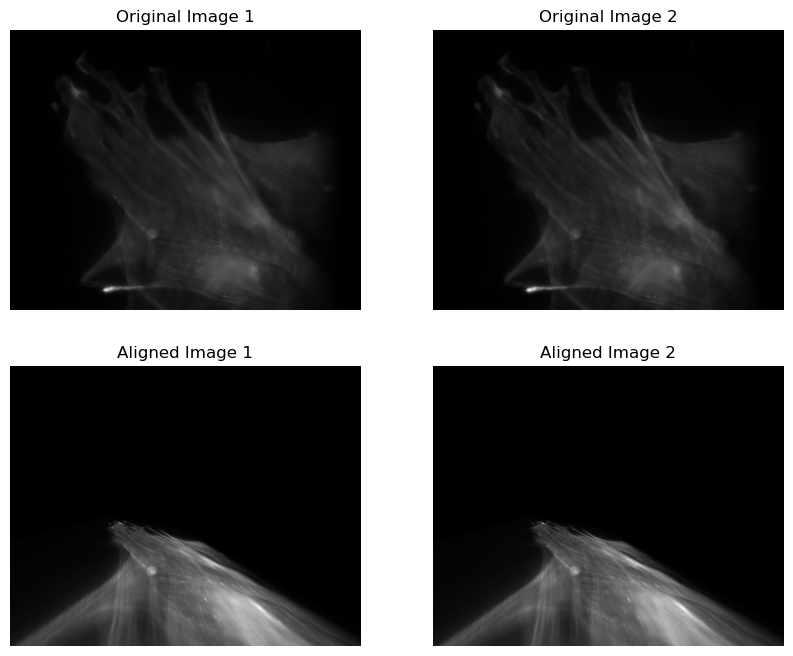

In [31]:
show_results(original_image1, original_image2, aligned_original_image1, aligned_original_image2)

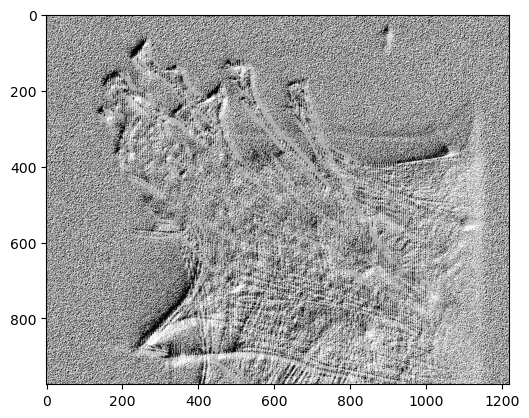

In [34]:
plt.imshow(sobel_frame2_8bit, cmap='gray')